In [21]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from math import sqrt
import tqdm
import os

class SteelDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, task):
        data = pd.read_csv(dataset_path, index_col=0).to_numpy()

        self.xs = data[:, 3:].astype(np.float32)
        self.ys = data[:, task:task+1].astype(np.float32)
        self.x_num = self.xs.shape[1]

    def __len__(self):
        return self.ys.shape[0]

    def __getitem__(self, index):
        return self.xs[index], self.ys[index]

class NetModule(torch.nn.Module):
    def __init__(self, x_num, dims, dropout):
        super().__init__()
        layers = list()
        input_dim = x_num
        for embed_dim in dims:
            layers.append(torch.nn.Linear(input_dim, embed_dim))
            layers.append(torch.nn.BatchNorm1d(embed_dim))
            layers.append(torch.nn.ReLU())
            layers.append(torch.nn.Dropout(p=dropout))
            input_dim = embed_dim
        layers.append(torch.nn.Linear(input_dim, 1))
        self.mlp = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)

In [68]:
class CheckSaver():
    def __init__(self, save_path):
        self.save_path = save_path
    def save(self, model, epoch_i):
        torch.save(model.state_dict(), os.path.join(self.save_path, f'epoch{epoch_i}.pt'))
        return

def train(model, optimizer, data_loader, criterion, device):
    model.train()
    total_loss = 0
    for i, (x, y) in enumerate(data_loader):
        x, y = x.to(device), y.to(device)
        pred_y = model(x)

        loss = criterion(pred_y, y.float())
        model.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

def test(model, data_loader, device):
    model.eval()

    y_list = []
    pred_list = []
    mse_list = []
    mae_list = []

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            pred_y = model(x)

            y_list.extend(y.tolist())
            pred_list.extend(pred_y.tolist())

            loss_mse = torch.nn.functional.mse_loss(pred_y, y.float(), reduction='none')
            loss_mae = torch.nn.functional.l1_loss(pred_y, y.float(), reduction='none')
            mse_list.extend(loss_mse.tolist())
            mae_list.extend(loss_mae.tolist())


    mse = np.array(mse_list).mean()
    rmse = sqrt(mse)
    mae = np.array(mae_list).mean()
    var = np.array(y_list).var()
    r2 = 1-mse/var
    return mse, mae, r2


def main(dirname,
         task,
         epoch,
         learning_rate,
         batch_size,
         weight_decay,
         device,
         save_dir):
    device = torch.device(device)

    train_dataset = SteelDataset(f'./processed_data/{dirname}/train.csv', task)
    test_dataset = SteelDataset(f'./processed_data/{dirname}/test.csv', task)
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
    test_data_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=0, shuffle=False)

    model = NetModule(train_dataset.x_num, dims=(1024,512,256), dropout=0.2).to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    saver = CheckSaver(save_path=save_dir)

    mses = []
    maes = []
    r2s = []
    for epoch_i in range(epoch):
        train(model, optimizer, train_data_loader, criterion, device)
        mse, mae, r2 = test(model, test_data_loader, device)
        print('epoch:', epoch_i,'task:',task)
        print('MSE {}, MAE {}, R2 {}'.format(mse, mae, r2))
        mses.append(mse)
        maes.append(mae)
        r2s.append(r2)
        # saver.save(model, epoch_i)
    return mses, maes, r2s

mses, maes, r2s = main(dirname='minmax_pca_25', task=0, epoch=200, learning_rate=0.002, batch_size=64, weight_decay=1e-6, device='cpu', save_dir='chkpt')

epoch: 0 task: 0
MSE 79204.41322746829, MAE 280.3770838751309, R2 -112.43569520723584
epoch: 1 task: 0
MSE 49574.534165534424, MAE 221.57530118417048, R2 -70.00010616191284
epoch: 2 task: 0
MSE 22900.199271824047, MAE 149.8619793601658, R2 -31.797415180934742
epoch: 3 task: 0
MSE 7461.3299277485285, MAE 84.08406619749208, R2 -9.686035197230424
epoch: 4 task: 0
MSE 1723.268286637422, MAE 37.02210915606955, R2 -1.4680460110460758
epoch: 5 task: 0
MSE 414.40278242111367, MAE 15.899127407350402, R2 0.40649686293680665
epoch: 6 task: 0
MSE 470.8375823677862, MAE 17.647299780361895, R2 0.32567155908098633
epoch: 7 task: 0
MSE 400.3585944822247, MAE 15.811342985733695, R2 0.42661079545081515
epoch: 8 task: 0
MSE 389.9841043778385, MAE 15.404019120810688, R2 0.4414690268227447
epoch: 9 task: 0
MSE 455.46203978157575, MAE 16.26171272388403, R2 0.34769224317400826
epoch: 10 task: 0
MSE 504.7555973248664, MAE 17.965891409611356, R2 0.27709454866041683
epoch: 11 task: 0
MSE 406.39679240093875, MAE

In [23]:
from tqdm import tqdm

res = []
for dirname in tqdm(os.listdir('./processed_data')):
    mse = main(dirname=dirname, task=0, epoch=10, learning_rate=0.01, batch_size=64, weight_decay=1e-6, device='cpu', save_dir='chkpt')
    res.append(mse)
np.save('simple_res.npy', np.array(res))

100%|██████████| 164/164 [58:36<00:00, 21.44s/it]


minmax_randomforest_26
minmax_randomforest_25


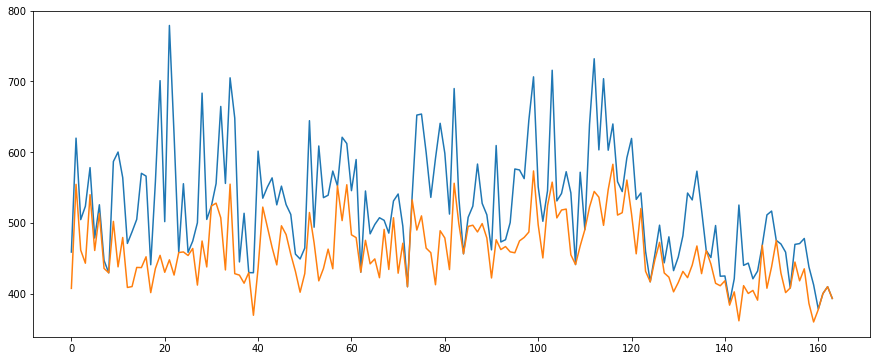

In [61]:
tmp = np.array(res)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 6))
plt.plot(tmp[:,9])
plt.plot(tmp.min(axis=1))
tmp[:,9].argmin()
print(os.listdir('./processed_data')[tmp[:,9].argmin()])
print(os.listdir('./processed_data')[tmp.min(axis=1).argmin()])